# 밑바닥부터 시작하는 딥러닝 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle

## 3.2.2. 계단함수, 시그모이드, Relu 구현 및 그래프

In [2]:
# 3.2.2. 계단함수 구하기

def step_function_(x):
    if x > 0 : return 1
    else : return 0
    
def step_function(x):
    # x가 0보다 크면 True(1) 반환 x 가 0보다 작으면 False(0) 반환
    y = x > 0 
    return y.astype(np.int)

In [3]:
# 시그모이드 함수
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

# Relu 함수
def relu(x) :
    return np.maximum(0,x)

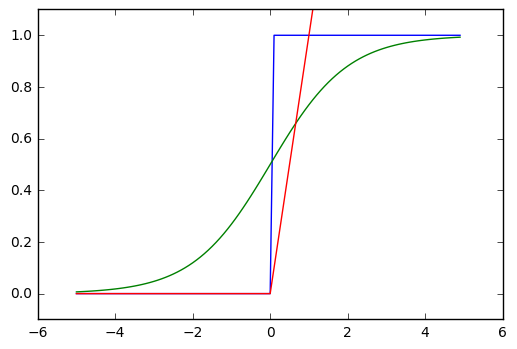

In [4]:
# 계단함수 사용 및 그래프
x = np.arange(-5.0, 5.0, 0.1)
y = step_function(x)
y1 = sigmoid(x)
y2 = relu(x)
plt.plot(x,y)
plt.plot(x,y1)
plt.plot(x,y2)
plt.ylim(-0.1, 1.1)
plt.show()

### 3층 신경망 구현

In [5]:
def init_network():
    # 비어있는 딕셔너리 생성
    network = {}
    # weight1,2,3 biase 1,2,3 생성후 딕셔너리에 할당
    network['W1'] = np.array([[0.1,0.3,0.5],[0.2,0.4,0.6]])
    network['b1'] = np.array([0.1,0.2,0.3])
    network['W2'] = np.array([[0.1,0.3],[0.2,0.4],[0.2,0.4]])
    network['b2'] = np.array([0.1,0.2])
    network['W3'] = np.array([[0.1,0.3],[0.2,0.4]])
    network['b3'] = np.array([0.1,0.2])
    
    return network

# 향후 softmax 함수 등으로 대체될 예정
def identity_function(x):
    return x

def forward(network, x) :
    # 각 변수에 weight, biase 할당
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    # 1차 hidden layer 계산
    a1 = np.dot(x, W1) + b1
    # 발화식 activation function
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    z3 = sigmoid(a3)
    y = identity_function(a3)

    return y

In [6]:
network = init_network()
x = np.array([1.0, 0.5])
y = forward(network, x)
print(y)

[ 0.30466121  0.67017533]


## 3.5 출력층 설계하기

### Softmax 함수 구현

In [7]:
def softmax_(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

##### 기본 softmax 함수 자체엔 문제가 없지만 a 값이 클 경우 e^a는 컴퓨터가 inf로 인식해 최종 결과값이 NaN 로 출력될 가능성 있어 조정 필요
##### 수식 유도 후 알 수 있듯이 지수 않에 분모,분자에 같은 상수를 더해주면 같은 값이 나오는 것을 확인할 수 없음
##### softmax 함수는 출력층에서 확률의 형태로 나오도록 도와주는 함수라 통계, 확률적으로 의미 있지만 one-hot vector outpur에서는
##### 단순 argmax로 충분함

In [8]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c) # 오버 플로우를 방지하기위해 입력된 리스트 중 최대 값을 빼준다.
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

## 3.6 MNIST 손글씨 함수

##### MNIST 손글씨 데이터 불러오기

In [9]:
import sys, os
sys.path.append(os.pardir)
# https://github.com/WegraLee/deep-learning-from-scratch 에서 data/mnist.py 파일 로드
from dataset.mnist import load_mnist
from PIL import Image

(x_train, t_train), (x_test, t_test) = load_mnist(flatten = True, normalize = False)

print(x_train.shape, t_train.shape, x_test.shape, t_test.shape)

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()
    
img = x_train[0].reshape(28, 28); print(img.shape)
label = t_train[0] ; print(label)

img_show(img)

(60000, 784) (60000,) (10000, 784) (10000,)
(28, 28)
5


### 3.6.2 신경망의 추론 처리

In [10]:
def get_data():
    (x_train, t_train), (x_test, t_test) =\
    load_mnist(normalize = True, flatten = True, one_hot_label=False)
    return x_test, t_test

def init_network():
    with open("sample_weight.pkl", 'rb') as f :
        network = pickle.load(f)
        
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    # 1차 hidden layer 계산
    a1 = np.dot(x, W1) + b1
    # 발화식 activation function
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    z3 = sigmoid(a3)
    y = softmax(a3)

    return y

###### 기존 학습된 모델 정확도 평가

In [11]:
x, t = get_data()
network = init_network()

accuracy_cnt = 0

for i in range(len(x)):
    y  = predict(network, x[i])
    p = np.argmax(y) # 확률이 가장 높은 원소의 인덱스를 얻는다
    if p == t[i] :
        accuracy_cnt += 1
        
print("Accuracy:" + str(float(accuracy_cnt / len(x))))

Accuracy:0.9352


###### 배치 처리를 통한 구현

In [12]:
x, t = get_data()
network = init_network()

batch_size = 100
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch)
    p = np.argmax(y_batch, axis = 1)
    accuracy_cnt += np.sum(p == t[i:i+batch_size])
    
print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


## Ch.4 신경망 학습 

### 4.2.1. 평균제곱오차

In [13]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


### 4.2.2. Cross Entropy Error

In [14]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

# y 가 0일경우 inf로 넘어가는 것 방지하기 위해 아주 작은 delta 값 더해줌
# t가 1 (정답)일 때 출력층의 softmax 확률의 -log 값이 반환됨

### 4.2.3. 미니배치 학습

In [15]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

### 4.2.4. 배치용 교차 엔트로피 오차 구현

In [16]:
def cross_entropy_error(y,t):
    if y.ndim == 1 :
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return - np.sum(t* np.log(y))/ batch_size

### 4.3. 수치미분

In [17]:
def numerical_diff(f,x): # f : function, x : x 값
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2 * h)



In [18]:
# 모든 변수의 편미분을 벡터로 정리한 것을 기울기(gradient)라고 함
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

### 경사하강법 gradient descent

In [19]:
def gradient_descent(f, init_x, lr=0.01, step_num = 100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f,x)
        x -= lr * grad
    return x

def function_2(x):
    return np.sum(x**2)
    
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x = init_x, lr = 0.1, step_num= 1000)




array([ -5.65129794e-21,   6.61744490e-21])

### 4.4.2. 신경망에서의 기울기

In [22]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)  # 정규분포 초기화
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y,t)
        
        return loss
    
net = simpleNet()
print(net.W)

[[ 1.33857783 -1.0745015  -1.01431443]
 [ 1.7669831   0.63050977 -0.12190082]]
